In [1]:
#package required
import torch
import torch.nn as nn
import shutil 
import PIL
import os 
from PIL import Image
import torchvision
from torchvision import transforms 
import torchvision.transforms as T
import matplotlib.pyplot as plt

# class dataset

In [2]:
class Dataset():
    """
    We transfer the kaggle dataset into a folder where the python environment is. 
    path_source is where the kaggle dataset downloaded is, path destination is where it should be placed the unzipped dataset.[by default there are my paths] 
    """
    def __init__(self,path_destination):

        self.path_destination = path_destination
        self.file_id = 0
        self.files = []
        self.true_labels = []
        

        !pip install unzip
        from google.colab import drive
        drive.mount('/content/gdrive')
        !cp /content/gdrive/MyDrive/NN_dataset/img_celeba_dataset.zip /content
        !unzip "/content/img_celeba_dataset.zip" -d "/content"
               
        
    def preprocessing(self,p_subset=0.25):
        
        """
        preprocessing function creates the dataset folder where a subset of the original images is taken 
        --- INPUT ---
        p_subset = the percentage of the image transfered to the dataset default = 0.25

        --- OUTPUT ---
        dataset folder with the preprocessed images. 
        Each image has undergone to the following processes
        1) crop it and centralized 
        2) downsampled to 64x64 resolution
        3) converted from a RGB to a grayscale image [computational reason]
        """

        self.p_subset = p_subset

        #creation of the path where the new dataset will be stored
        self.path_dataset = os.path.join(os.getcwd(),"dataset")
        os.mkdir(self.path_dataset)

        self.counter_photos = 0
        self.counter_dataset = 0

        for photo in os.listdir(self.path_destination):

            self.counter_photos = self.counter_photos +1
            if torch.rand(1) <= p_subset:

                self.counter_dataset = self.counter_dataset +1
                #directory of each photo example (../img_celeba_dataset/19736.jpeg)
                dir = os.path.join(self.path_destination,photo)

                #in sequence, I open the photo, crop it, resize(downsampled to a 64x64 resolution)   
                im = Image.open(dir).crop((20,45,150,185)).resize((64,64))#140x140 
                #save the new image into that directory
                im.save(str(self.path_dataset+"/"+"real_"+photo))

        print("counter photos {} counter dataset {} ratio {}".format(self.counter_photos,self.counter_dataset, self.counter_dataset/self.counter_photos))

    
    def shuffled_dataset(self,boolean_shuffle=True):

        """
        mixed the dataset, by returning a list containing the path of every single image, which will be needed when we have to upload the mini batch
        a trivial example of an entries of self.files is like: "/Users/tommasoancilli/Desktop/Python/NN_proj/dataset/real_8328239.jpg"
        """
        self.path_dataset = os.path.join(os.getcwd(),"dataset/")

        self.files = [os.path.join(self.path_dataset,f) for f in os.listdir(self.path_dataset)]
        self.true_labels = [1]*len(self.files)

        if boolean_shuffle:
            shuffled_list = torch.randperm(len(self.files))

            self.files = [self.files[i] for i in shuffled_list]
            self.true_labels = [self.true_labels[i] for i in shuffled_list]

        return self.files, self.true_labels


    def load_and_conversion(self,file_img):

        """
        it loads and converts the images into a tensor format 
        ----- INPUT -----

        ----- OUTPUT -----

        img_tensor : tensor of the image, being converted from a .jpg format to a tensor one
        label_tensor : tensor of the label 
        end_dataset : flag showing the bottom of the dataset 
        """
        self.files = file_img
        self.end_dataset = False

        im = Image.open(self.files[self.file_id])
        label = self.true_labels[self.file_id]
         
        convert_tensor = transforms.ToTensor()

        img_tensor = convert_tensor(im)
        label_tensor = torch.tensor(label)

        if self.file_id < len(self.files)-1:
            self.file_id = self.file_id +1
        else:
            self.end_dataset = True
            self.file_id = 0 #reset the index


        return img_tensor,label_tensor,self.end_dataset



    def mini_batch_creation(self, batch_size:int,file_img):
        """
        create the a batch containing the images processed
        ------ INPUT ------
        batch_size: given by the users 

        ----- OUTPUT -----
        mini_batch_image: batch of images, its shape is a 4D tensor #batch_size x #channels x width x height
        mini_batch_labels: batch of labels, its a tensor: 1 x #batch_size 
        last_batch_flag: flag variable to say when we have reached the last batch. In this way, in the training function it will indicate the end of a epoch 


        """
        i = 0
        self.data_batch_im = []
        self.data_batch_label = []

        last_batch_flag = False

        while i < batch_size:
            
            img,label,end_dataset_flag = self.load_and_conversion(file_img)

            self.data_batch_im.append(img)
            self.data_batch_label.append(label)
            last_batch = end_dataset_flag

            i = i + 1

            if last_batch:
                last_batch_flag = True
                break
        
        mini_batch_image = torch.stack(self.data_batch_im,dim=0)
        mini_batch_label = torch.stack(self.data_batch_label,dim=0).view(1,-1)

        return mini_batch_image, mini_batch_label, last_batch_flag





# ANN

In [3]:
class Generator(): #può sia essere il Generator nelle GAN che una classica NN negli adversarial attack

    """
    input: tensor (5,5,5) x,y,z dimension

    output: tenror (64,64,3) xyz

    Inner structure: with the parameter "structure" an autoencoder net or a paper-based net can be deployed   
    """

    def __init__(self,processing_unit,structure):
        
        if structure == "CNN":
          self.layers = []

          self.layers.append(nn.Conv2d(3, 64, kernel_size=3, padding=1)) #stride = 1 default
          self.layers.append(nn.LeakyReLU(negative_slope=0.01, inplace=True))#layers.append(nn.ReLU(inplace=True))

          self.layers.append(nn.Conv2d(64, 128, kernel_size=5,padding=2)) #stride = 1 default
          self.layers.append(nn.LeakyReLU(negative_slope=0.01, inplace=True))

          #depthwise separable CNN layer
          #self.layers.append(nn.Conv2d(128,128,kernel_size=7,padding=3,groups=128))
          #self.layers.append(nn.Conv2d(128,256,kernel_size=1))
          self.layers.append(nn.Conv2d(128, 256, kernel_size=7, padding=3)) #stride = 1 default
          self.layers.append(nn.LeakyReLU(negative_slope=0.01, inplace=True))

          self.layers.append(nn.Conv2d(256, 64, kernel_size=3, padding=1)) #stride = 1 default
          self.layers.append(nn.ReLU(inplace=True))

          self.layers.append(nn.Conv2d(64, 3, kernel_size=3, padding=1)) #stride = 1 default
          self.layers.append(nn.ReLU(inplace=True))

          self.net = nn.Sequential(*self.layers)

          self.input_shape = (3,64,64)

        
        elif structure == "conventional":
        
          self.layers = []

          self.layers.append(nn.ConvTranspose2d(in_channels=5,out_channels=128,kernel_size=4,padding=2,stride=1))#[5,5,5] -> [4,4,128]
          self.layers.append(nn.ReLU())
          self.layers.append(nn.BatchNorm2d(128))

          self.layers.append(nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=3,padding=2,stride=3))#[4,4,128] -> [8,8,64]
          self.layers.append(nn.ReLU())
          self.layers.append(nn.BatchNorm2d(64))

          self.layers.append(nn.ConvTranspose2d(in_channels=64,out_channels=32,kernel_size=4,padding=1,stride=2))#[8,8,64] -> [16,16,32]
          self.layers.append(nn.ReLU())
          self.layers.append(nn.BatchNorm2d(32))

          self.layers.append(nn.ConvTranspose2d(in_channels=32,out_channels=16,kernel_size=4,padding=1,stride=2))#[16,16,32] -> [32,32,16]
          self.layers.append(nn.ReLU())

          self.layers.append(nn.ConvTranspose2d(in_channels=16,out_channels=3,kernel_size=2,padding=0,stride=2))#[32,32,16] -> [64,64,3]
          self.layers.append(nn.ReLU())

          self.net = nn.Sequential(*self.layers)

          self.input_shape = (5,5,5)

        

        self.device = torch.device(processing_unit)
        self.net = self.net.to(self.device)
        self.position = 0


    
    def forward_G(self, x_input:torch.tensor):

      """
      ----- Input -----
      x_input -> tensor, dimension #example_mini_batch x #channels x width x height 

      ----- Output ----
      self.image_output -> tensor, dimension #example_mini_batch #channels x width x height 
      self.label_fake_img -> tensor, dimension 1 x #example_mini_batch

      """

      self.image_output = self.net(x_input)
      self.label_fake_img = torch.tensor([[0]*len(x_input)])

      return self.image_output,self.label_fake_img


    def function_loss_G(self,output_label_gen:torch.tensor,true_label:torch.tensor):
      """
      ----- INPUT -----
      output_label_gen -> tensor 1 x #batch_sample
      true_label -> tensor 1 x #batch_sample
      ----- OUTPUT -----

      loss function. 
      (it is negative because we want to maximize and generally backprop follows the discent of the gradient, so the max = - min )
      """
      cost_function = nn.BCELoss()
      true_label = true_label.to(torch.float) #aggiunto questo 
      loss = cost_function(output_label_gen,true_label)#-cost_function(output_label_gen,true_label)

      return loss


    def image_generation(self):
      """
      This function will be used to display a image after the ending of batch/epoch...
      """

      #creation of a tuple (1,self.input_shape)
      self.net.load_state_dict(torch.load("weights_generator.pth", map_location=self.device))
      random_input = torch.rand(size= (1,)+self.input_shape)
      random_input = random_input.to(self.device)
      transform = T.ToPILImage()#function to transform a tensor into a image
      out = self.net(random_input)
      #since our input is a 4D tensor, to create a RGB image we have to change their view
      out = out.view(out.shape[0]*out.shape[1],out.shape[2],out.shape[3])
      im = transform(out)

      return im#im.show()
      
    def creation_image(self, length_dataset:int):

      """
        create a single (4D) tensor image

        ----- INPUT -----
        length_dataset -> int value

        ----- OUTPUT ------
        a tensor image (img) and a boolean function if the we have reached the end of the dataset
      """

      img = torch.rand(self.input_shape)

      end_dataset = False
      
      if self.position <  length_dataset -1:
        self.position = self.position +1 
      else:
        self.position = 0
        end_dataset = True

      return img, end_dataset
    
    def input_creation(self,length_dataset:int,batch_size:int,current_batch_dim = None):
      """
      This function create a tensor for feeding the generator net. dimension (batch_size x channels x width x height)
      If current_batch_dim = None, the output is feed into the discriminator without propagating the gradient till the generator. The presence of this parameter indicates whether the discrimiator is trained or not.

      ----- INPUT -----
      length_dataset -> int value 
      batch_size -> int value

      ----- OUTPUT -----
      batch_input, 4D tensor: #sample_batch x #channels x width x height  
      """
      if current_batch_dim == None:

        length_dataset = length_dataset
        i = 0
        self.batch_input = []

        last_batch = False

        while i < batch_size:

          img,end_dataset_flag = self.creation_image(length_dataset)
          self.batch_input.append(img)
          last_batch = end_dataset_flag

          i = i + 1
        
          if last_batch:
            break

        self.batch_input = torch.stack(self.batch_input,dim = 0)

      else:
        
        last_batch = False
        
        self.batch_input = torch.rand((current_batch_dim))


      return self.batch_input, last_batch


    def summary(self):
      """
      summary of the model 
      """
      for idx,l in enumerate(self.layers):
        print(idx+1, "->",l)
        if "LU" in str(l):
          print("\n")
    
    def save(self,file_name):
      torch.save(self.net.state_dict(), file_name)



class Discriminator():

    def __init__(self,processing_unit):
        self.layers = []

        self.layers.append(nn.Conv2d(3,32,kernel_size=7,padding = "same"))#64x64x32
        self.layers.append(nn.AvgPool2d(2,stride=2))#32x32x32
        self.layers.append(nn.LeakyReLU(inplace=True))

        self.layers.append(nn.Conv2d(32,64,kernel_size=5,padding="same"))#32x32x64
        self.layers.append(nn.AvgPool2d(2,stride=2))#16x16x64
        self.layers.append(nn.LeakyReLU(inplace=True))

        self.layers.append(nn.Conv2d(64,128,kernel_size=3,padding=1,stride=2))#8x8x128
        self.layers.append(nn.ReLU(inplace=True))

        self.layers.append(nn.Conv2d(128,256,kernel_size=3,padding=1,stride=2))#4x4x256
        self.layers.append(nn.ReLU(inplace=True))

        self.layers.append(nn.Flatten())#256X16

        self.layers.append(nn.Linear(in_features=256*4*4,out_features=1))

        self.layers.append(nn.Sigmoid())

        self.net = nn.Sequential(*self.layers)

        self.device = torch.device(processing_unit)
        self.net = self.net.to(self.device)

    
    def combined_True_Fake(self, fake_labels:torch.tensor, fake_images:torch.tensor, true_labels:torch.tensor, true_images:torch.tensor):
      """
      The true and generated images are combined together 
        ----- Input ----
        fake_labels, fake_images, true_labels, true_images -> tensor
        dimensions:
        fake_images, true images = #of_example_mini_batch x #channles x width x height
        fake/true labels = 1x#of_example_mini_batch

        ----- Output ------
        combined_images, combined_label -> tensor
        dimension:
        combined_label = 1 x #examples_mini_batch
        combined_images = 2*#examples_mini_batch x width x height 

      """


      combined_images = torch.stack([true_images,fake_images],dim=0)
      # combined_images dimension = 2(number of tensor combined into a list) x #mini_batches x channels x width x height
      combined_images = combined_images.view(
        combined_images.shape[0]*combined_images.shape[1],
        combined_images.shape[2],combined_images.shape[3],combined_images.shape[4]
      )
      #with view I reshape the dimension, compressing the first two dimention into a single one.
      #it's like pilling up the tensor one after the other in the dimension of the mini batches 

      #hstack -> it stacks the tensor horizionally, so from two tensor of shape [1,n] and [1,n] it prints out [1,2*n]
      combined_labels = torch.hstack([true_labels,fake_labels])
      combined_labels = combined_labels.view(-1,1)
      #view(-1,1) it's like numpy.reshape and it "transpose" creating a [2*n,1] vector 

      return combined_images,combined_labels

    def forward_D(self,images:torch.tensor):
      """
      ----- INPUT -----
      image -> tensor 2*#batch_size x #channels x width x height

      ----- OUTPUT -----
      tensor -> 2*#batch_size x 1
      """
      self.output = self.net(images)
      self.output = self.output.to(torch.float32) #aggiunto questo 
      return self.output 
      
    def function_loss_D(self,output_label_dis:torch.tensor,true_label:torch.tensor):
      """
      ----- INPUT -----
      output_label_dis -> 2*#batch_size x 1
      true_label -> 2*#batch_size x 1 
      
      ----- OUTPUT -----
      loss function

      """
      cost_function = nn.BCELoss()
      true_label = true_label.to(torch.float) #aggiunto questo 
      loss = cost_function(output_label_dis,true_label)

      return loss

    def save(self,file_name):
      torch.save(self.net.state_dict(), file_name)

    def summary(self):
      """
      summary of the model 
      """
      for idx,l in enumerate(self.layers):
        print(idx+1, "->",l)
        if "LU" in str(l):
          print("\n")

# Train functions

In [4]:

def train_lr(architecture_G,architecture_D,batch_size:int,n_epochs:int,dataset,lr_g:int,lr_d:int,processing_unit,p_subset:int):

    """
    This function perform the first solution proposed by the paper on how to train the Generator/Discriminator

    ----- INPUT -----
    Generator -> class of the generator
    Discriminator -> class of the discriminator
    batch_size,n_epochs,lr -> number
    dataset -> -> object dataset  

    ----- OUTPUT -----
    metrics to measure the accuracy of the models 

    """

    gen_net = architecture_G
    dis_net = architecture_D
    best_epoch_G = -1
    best_epoch_D = -1

    dataset.preprocessing(p_subset) 
    
    
    optimizer_gen = torch.optim.Adam([p for p in gen_net.net.parameters() if p.requires_grad], lr_g, maximize=True) 
    optimizer_dis = torch.optim.Adam([p for p in dis_net.net.parameters() if p.requires_grad], lr_d, maximize=False)

    best_loss_D = 1000000000000 
    best_loss_G = 1000000000000

    gen_net.net.train()
    dis_net.net.train()

    loss_G_batch = []
    loss_D_batch = []


    for e in range(0,n_epochs):


        last_batch = False

        image_file, _ = dataset.shuffled_dataset()
        length_dataset = len(image_file)

        counter_batches = 0
        avg_loss_D = 0
        avg_loss_G = 0

        while not last_batch:

            counter_batches = counter_batches + 1

            #fake batch creation
            x_gen_input, _ = gen_net.input_creation(length_dataset = length_dataset , batch_size = batch_size)
            current_batch_dim = x_gen_input.shape

            with torch.no_grad():
                #move the data into the processing unit device
                x_gen_input = x_gen_input.to(processing_unit)
                #fake image generated by Generator
                image_output_fake,label_fake_img = gen_net.forward_G(x_gen_input)

            #true image generation
            mini_batch_image_real, mini_batch_label_real, last_batch_flag = dataset.mini_batch_creation(batch_size,image_file)

            #combination real/fake image into the cpu
            image_output_fake = image_output_fake.to('cpu')
            label_fake_img = label_fake_img.to('cpu')
            mini_batch_img_comb, mini_batch_lab_comb  = dis_net.combined_True_Fake(
                fake_labels = label_fake_img, fake_images = image_output_fake, 
                true_labels = mini_batch_label_real , true_images = mini_batch_image_real
            )

            #relocate the combined images into the processing unit 
            mini_batch_img_comb = mini_batch_img_comb.to(processing_unit)
            predicted_label = dis_net.forward_D(mini_batch_img_comb)

            #------------
            # BackProp Discriminator 
            #------------
            
            #move to processing unit 
            predicted_label = predicted_label.to(processing_unit)
            mini_batch_lab_comb = mini_batch_lab_comb.to(processing_unit)

            loss_dis = dis_net.function_loss_D(output_label_dis = predicted_label,true_label = mini_batch_lab_comb)
            loss_D_batch.append(loss_dis.item())

            avg_loss_D = avg_loss_D + loss_dis
            print("loss DISCRIMINATOR,", loss_dis ,avg_loss_D)

            optimizer_dis.zero_grad()
            loss_dis.backward()
            optimizer_dis.step()


            #----------
            #BackProp Generator
            #----------

            x_gen_input,_ = gen_net.input_creation(length_dataset = length_dataset , batch_size = batch_size, current_batch_dim = current_batch_dim)
            x_gen_input = x_gen_input.to(processing_unit)

            image_output_fake,fake_target = gen_net.forward_G(x_gen_input)

            predicted_label_generated = dis_net.forward_D(image_output_fake)
            fake_target = fake_target.view(-1,1)

            #move to processing unit
            predicted_label_generated = predicted_label_generated.to(processing_unit)
            fake_target = fake_target.to(processing_unit)

            loss_gen = gen_net.function_loss_G(output_label_gen = predicted_label_generated, true_label = fake_target)

            loss_G_batch.append(loss_gen.item())
            avg_loss_G = avg_loss_G + loss_gen 

            print("loss GENERATOR", loss_gen, avg_loss_G)

            optimizer_gen.zero_grad()
            loss_gen.backward()
            optimizer_gen.step()
            

            last_batch = last_batch_flag




        avg_loss_G = avg_loss_G/counter_batches
        avg_loss_D = avg_loss_D/counter_batches

        if avg_loss_D < best_loss_D:
            best_loss_D = avg_loss_D
            best_epoch_D = e + 1
            dis_net.save("weights_discriminator.pth")
            
        if avg_loss_G < best_loss_G:
          best_loss_G = avg_loss_G
          best_epoch_G = e + 1
          gen_net.save("weights_generator.pth")

       
        print("epoch:{0}/{1}".format(e+1,n_epochs)) 
              
        print(("DISCRIMIATOR: BCE LOSS={0:.4f}"
                   + (", BEST!" if avg_loss_D == best_loss_D else ""))
                  .format(avg_loss_D))
            
        print(("GENERATOR: BCE LOSS={0:.4f}"
                   + (", BEST!" if avg_loss_G == best_loss_G else ""))
                  .format(avg_loss_G))
            
        print("========================================================================================= \n")

    plt.plot(loss_G_batch)
    plt.plot(loss_D_batch)
    plt.legend(["Generator Loss","Discriminator Loss"])
    plt.xlabel("# mini-batchs")
    plt.ylabel("avg error on each mini-batch")
    plt.show()




def train_lr_obj(architecture_G,architecture_D,batch_size:int,n_epochs:int,dataset,lr_g:int,lr_d:int,processing_unit,p_subset:int):

    """
    Here I modify the learning rate and also the cost function of the Generator. Indeed, now I do not maximize sum(-(1-y)log(D(G))) but rather
    I aim to minizime sum(ylog(D(G))). For this reason i falsly impose y = 1. 

    ----- INPUT -----
    Generator -> class of the generator
    Discriminator -> class of the discriminator
    batch_size,n_epochs,lr -> number
    dataset -> -> object dataset  

    ----- OUTPUT -----
    metrics to measure the accuracy of the models 

    """

    gen_net = architecture_G
    dis_net = architecture_D
    best_epoch_G = -1
    best_epoch_D = -1

    dataset.preprocessing(p_subset) 
    

    
    optimizer_gen = torch.optim.Adam([p for p in gen_net.net.parameters() if p.requires_grad], lr_g, maximize=False) 
    optimizer_dis = torch.optim.Adam([p for p in dis_net.net.parameters() if p.requires_grad], lr_d, maximize=False)

    best_loss_D = 1000000000000 
    best_loss_G = 1000000000000

    gen_net.net.train()
    dis_net.net.train()

    loss_G_batch = []
    loss_D_batch = []

    for e in range(0,n_epochs):


        last_batch = False

        image_file, _ = dataset.shuffled_dataset()
        length_dataset = len(image_file)

        counter_batches = 0
        avg_loss_D = 0
        avg_loss_G = 0

        while not last_batch:

            counter_batches = counter_batches + 1

            #fake batch creation
            x_gen_input, _ = gen_net.input_creation(length_dataset = length_dataset , batch_size = batch_size)
            current_batch_dim = x_gen_input.shape

            with torch.no_grad():
                #move the data into the processing unit device
                x_gen_input = x_gen_input.to(processing_unit)
                #fake image generated by Generator
                image_output_fake,label_fake_img = gen_net.forward_G(x_gen_input)

            #true image generation
            mini_batch_image_real, mini_batch_label_real, last_batch_flag = dataset.mini_batch_creation(batch_size,image_file)

            #combination real/fake image into the cpu
            image_output_fake = image_output_fake.to('cpu')
            label_fake_img = label_fake_img.to('cpu')
            mini_batch_img_comb, mini_batch_lab_comb  = dis_net.combined_True_Fake(
                fake_labels = label_fake_img, fake_images = image_output_fake, 
                true_labels = mini_batch_label_real , true_images = mini_batch_image_real
            )

            #relocate the combined images into the processing unit 
            mini_batch_img_comb = mini_batch_img_comb.to(processing_unit)
            predicted_label = dis_net.forward_D(mini_batch_img_comb)

            #------------
            # BackProp Discriminator 
            #------------
            
            #move to processing unit 
            predicted_label = predicted_label.to(processing_unit)
            mini_batch_lab_comb = mini_batch_lab_comb.to(processing_unit)

            loss_dis = dis_net.function_loss_D(output_label_dis = predicted_label,true_label = mini_batch_lab_comb)
            
            loss_D_batch.append(loss_dis.item())

            avg_loss_D = avg_loss_D + loss_dis
            print("loss DISCRIMINATOR,", loss_dis ,avg_loss_D)

            optimizer_dis.zero_grad()
            loss_dis.backward()
            optimizer_dis.step()


            #----------
            #BackProp Generator
            #----------

            x_gen_input,_ = gen_net.input_creation(length_dataset = length_dataset , batch_size = batch_size, current_batch_dim = current_batch_dim)
            x_gen_input = x_gen_input.to(processing_unit)

            image_output_fake,_ = gen_net.forward_G(x_gen_input)
            
            predicted_label_generated = dis_net.forward_D(image_output_fake)

            #move to processing unit
            predicted_label_generated = predicted_label_generated.to(processing_unit)
            mini_batch_label_real = mini_batch_label_real.view(-1,1).to(processing_unit)#mini_batch_label_real is a tensor full of 1s

            loss_gen = gen_net.function_loss_G(output_label_gen=predicted_label_generated, true_label=mini_batch_label_real)    

            loss_G_batch.append(loss_gen.item())
            avg_loss_G = avg_loss_G + loss_gen 

            print("loss GENERATOR", loss_gen, avg_loss_G)


            optimizer_gen.zero_grad()
            loss_gen.backward()
            optimizer_gen.step()
            

            last_batch = last_batch_flag



        avg_loss_G = avg_loss_G/counter_batches
        avg_loss_D = avg_loss_D/counter_batches

        if avg_loss_D < best_loss_D:
            best_loss_D = avg_loss_D
            best_epoch_D = e + 1
            dis_net.save("weights_discriminator.pth")
            
        if avg_loss_G < best_loss_G:
          best_loss_G = avg_loss_G
          best_epoch_G = e + 1
          gen_net.save("weights_generator.pth")

       
        print("epoch:{0}/{1}".format(e+1,n_epochs)) 
              
        print(("DISCRIMIATOR: BCE LOSS={0:.4f}"
                   + (", BEST!" if avg_loss_D == best_loss_D else ""))
                  .format(avg_loss_D))
            
        print(("GENERATOR: BCE LOSS={0:.4f}"
                   + (", BEST!" if avg_loss_G == best_loss_G else ""))
                  .format(avg_loss_G))
            
        print("========================================================================================= \n")

    plt.plot(loss_G_batch)
    plt.plot(loss_D_batch)
    plt.legend(["Generator Loss","Discriminator Loss"])
    plt.xlabel("# mini-batchs")
    plt.ylabel("avg error on each mini-batch")
    plt.show()



# main

In [ ]:
processing_unit = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 128
epochs = 10
p_subset = 0.25
lr_g = 0.001
lr_d = 0.00001
dataset = Dataset(path_destination="/content/img_celeba_dataset")
gen_net = Generator(processing_unit,"conventional")
dis_net = Discriminator(processing_unit)

train_lr(architecture_G=gen_net,architecture_D=dis_net,batch_size=batch_size,n_epochs=epochs,dataset=dataset,lr_g=lr_g,lr_d=lr_d,processing_unit = processing_unit,p_subset=p_subset)



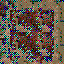

In [8]:
gen_net.image_generation()